## Notes: 
- Add skip layers?

Also will only run on colab because the training loop moves memory over to the gpu

In [1]:
!pip install pandas

!pip install d2l==0.17.6
!pip install matplotlib
!pip install matplotlib-inline

!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.


In [2]:
import cv2
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
!git clone -b @olly-branch "https://github.com/BSteiner1/ST311-Group-Project/"

Cloning into 'ST311-Group-Project'...
remote: Enumerating objects: 2168, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 2168 (delta 76), reused 132 (delta 42), pack-reused 1998
Receiving objects: 100% (2168/2168), 1.20 GiB | 37.13 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Updating files: 100% (2019/2019), done.


### Data Loading (Spectrogram)

In [4]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

In [5]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("ST311-Group-Project/Data/images_original"):
        for image in os.listdir("ST311-Group-Project/Data/images_original/" + genre):
            image_path = "ST311-Group-Project/Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            #grayscale_img = torch.tensor(grayscale_img, requires_grad=True)
            # Splitting each image vertically into 5 different parts
            #for i in range(5):
                # The data loader adds a dimension so I've removed a dimension from the image and class
                #data.append((grayscale_img[ : ,  (67*i):67*(i+1)].reshape(1,217,67), torch.tensor(class_dict.get(genre)))) #.reshape(1)))
            
            data.append((grayscale_img.reshape(1,217,335), torch.tensor(class_dict.get(genre))))

    return data         


In [6]:
data = collect_data()

In [7]:
len(data)

999

In [8]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

### Data Loading (Features)

Checked with 3 second features and it works way better, but had to keep 30 second since the data can be merged easier in the ensemble 

In [10]:
feature_path = "ST311-Group-Project/Data/features_30_sec - edited.csv"

In [11]:
raw_df = pd.read_csv(feature_path)
raw_df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.0645,2002.449060,85882.76132,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.0736,2039.036516,213843.75550,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.6434,1747.702312,76254.19226,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.9424,1596.412872,166441.49480,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.9393,1748.172116,88445.20904,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [12]:
del raw_df['filename']
del raw_df['length']
raw_df['label'] = raw_df['label'].map(class_dict)

In [13]:
df = StandardScaler().fit_transform(raw_df.iloc[:, 0:-1])
df = pd.DataFrame(df, columns = raw_df.columns.tolist()[:-1])
df['label'] = raw_df['label']

In [14]:
metadata = [(torch.tensor(list(df.loc[i][:-1])).clone().detach().requires_grad_(True).reshape(1,1,-1), torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

In [15]:
len(metadata)

999

In [16]:
meta_train_size = int(0.85 * len(metadata))
meta_test_size = len(metadata) - meta_train_size
metadata_train_dataset, metadata_test_dataset = torch.utils.data.random_split(metadata, [meta_train_size, meta_test_size])

In [17]:
metadata_train_loader = DataLoader(metadata_train_dataset, batch_size=40, shuffle=True)
metadata_test_loader = DataLoader(metadata_test_dataset, batch_size=20, shuffle=False)

### Train CNN 

In [142]:
'''
Parameters
'''

cnn_epochs = 100
cnn_lr = 0.01
cnn_batch_size = 10

'''
Net

'''

net3 = nn.Sequential(
    
    nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64,128, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(),

    nn.MaxPool2d(kernel_size = 3, stride = 3),

    nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = "same"), nn.ReLU(), #Previously went to 64

    nn.Flatten(),

    nn.Linear(15360, 128), nn.Dropout(0.2), nn.ReLU(), #Previously started at 3840

    nn.Linear(128, 100), nn.Dropout(0.2), nn.ReLU(), #nn.Linear(128, 64), nn.Dropout(0.2), nn.ReLU()

    #nn.Linear(64,32), nn.Dropout(0.2), nn.ReLU(),

    #nn.Linear(32,10), nn.ReLU(),

)

In [ ]:
d2l.train_ch6(net3, train_loader, test_loader, cnn_epochs, cnn_lr, d2l.try_gpu())

### MLP Training

In [143]:
'''

Notes:

- Made the network more complex, didnt have any effect on performance

- Added dropout after each layer, made the training and test acc crash at about epoch 40 

- Changed sigmoid to relu

'''


model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(57, 128), #nn.Linear(57, 32)
    nn.ReLU(),
    #nn.Linear(50, 40),
    #nn.Sigmoid(),
    #nn.Linear(40, 32),
    #nn.Sigmoid(),
    nn.Linear(128, 128),#nn.Linear(32, 16)
    nn.ReLU(),
    #nn.Linear(28, 16),
    #nn.Sigmoid(),
    nn.Linear(128, 100) #nn.Linear(16, 10)
)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(model.parameters(), lr=0.3)
meta_epochs = 200

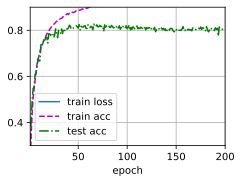

In [ ]:
d2l.train_ch3(model, metadata_train_loader, metadata_test_loader, loss, meta_epochs, trainer)

### Ensemble (Test Acc. 85)

Data Loading:

In [144]:
joined_data = [(data[i][0], metadata[i][0], torch.tensor(df['label'][i], dtype=torch.long)) for i in range(len(df))]

In [133]:
joined_data[0]

(tensor([[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [ 21., 110., 109.,  ..., 102., 121.,  96.],
          [ 21., 110., 109.,  ..., 102., 121.,  96.],
          [  0.,   3.,   5.,  ...,  55.,  97.,  99.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([[[-0.3515,  0.3121, -0.0102, -0.0619, -0.5842, -0.8485, -0.4564,
           -0.5303, -0.4871, -0.6615, -0.4929, -0.7350,  0.1905, -0.3740,
            0.3719,  0.0037,  0.1269,  0.3087, -0.4281,  0.7036, -0.9358,
           -0.4722, -0.8114,  0.3637, -0.5974, -0.4268, -0.0651,  0.3363,
           -0.5567, -0.8625, -0.8357,  0.4987, -0.4703, -0.6369, -0.1614,
            0.4086, -0.5006, -0.3379, -0.3617,  0.6445, -0.5346,  0.1822,
           -0.8044,  0.7917, -0.7032, -0.2647, -0.3865, -0.0868, -0.2465,
            0.4999, -0.7801, -0.2375, -0.6429,  0.0066, -0.3008,  0.6037,
           -0.5122]]], gr

In [134]:
joined_train_size = int(0.8 * len(joined_data))
joined_test_size = len(joined_data) - joined_train_size
joined_train_dataset, joined_test_dataset = torch.utils.data.random_split(joined_data, [joined_train_size, joined_test_size])

In [135]:
joined_train_loader = DataLoader(joined_train_dataset, batch_size=30, shuffle=True)
joined_test_loader = DataLoader(joined_test_dataset, batch_size=30, shuffle=False)

Net

In [136]:
'''
Notes:

- Added more linear layers at the end, didnt effect performance


'''

class cnn_mlp(nn.Module):
    def __init__(self):
        super(cnn_mlp, self).__init__()

        #Net to process images
        self.net3 = net3

        #Net to process features
        self.model = model

        self.fc1 = nn.Linear(200, 100)

        self.fc2 = nn.Linear(100,10)

    def forward(self, x1, x2):

        #Pass image through first subnetwork
        out1 = self.net3(x1)

        out1.size()

        #Pass features through second subnetwork
        out2 = self.model(x2)

        out2.size()

        #Concatenate
        out = torch.cat((out1, out2), dim = 1)

        out.size()
        
        #Pass through linear layer
        x = self.fc1(out)

        x = self.fc2(x)

        return x

Training

In [137]:
# Define instance of ensemble

#to.('cuda') ensures loop runs on colab gpu

cnn_mlp = cnn_mlp().to('cuda')

In [138]:
#Define Loss and optimiser

cnn_mlp_optimizer = torch.optim.Adam(cnn_mlp.parameters(), lr=0.0001)
cnn_mlp_loss = nn.CrossEntropyLoss()

In [139]:
#Define Epochs

cnn_mlp_epochs = 50

In [140]:
#Main Loop

'''
Notes:

- Reduced lr to 0.001 from 0.01, Made the model slightly better

- Increased batch size to 30

'''

for epoch in range(cnn_mlp_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs1, inputs2, targets) in enumerate(joined_train_loader):
      
        #Moves inputs to the gpu
        inputs1 = inputs1.to('cuda')
        inputs2 = inputs2.to('cuda')
        targets = targets.to('cuda')

        # Zero the gradients
        cnn_mlp_optimizer.zero_grad()
        
        # Forward pass
        outputs = cnn_mlp(inputs1, inputs2)
        loss = cnn_mlp_loss(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        cnn_mlp_optimizer.step()
        
        # Compute running loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Compute validation loss and accuracy
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs1, inputs2, targets in joined_test_loader:

            #Moves inputs to gpu
            inputs1 = inputs1.to('cuda')
            inputs2 = inputs2.to('cuda')
            targets = targets.to('cuda')
            
            outputs = cnn_mlp(inputs1, inputs2)
            loss = cnn_mlp_loss(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
    
    # Print epoch statistics
    print('Epoch %d: Train Loss: %.3f | Train Acc: %.3f%% | Val Loss: %.3f | Val Acc: %.3f%%'
          % (epoch+1, running_loss/len(joined_train_loader), 100*correct/total,
             val_loss/len(joined_test_loader), 100*val_correct/val_total))

Epoch 1: Train Loss: 2.277 | Train Acc: 14.518% | Val Loss: 2.212 | Val Acc: 23.000%
Epoch 2: Train Loss: 2.109 | Train Acc: 25.156% | Val Loss: 2.055 | Val Acc: 21.000%
Epoch 3: Train Loss: 1.926 | Train Acc: 30.663% | Val Loss: 1.927 | Val Acc: 28.500%
Epoch 4: Train Loss: 1.787 | Train Acc: 35.920% | Val Loss: 1.737 | Val Acc: 31.500%
Epoch 5: Train Loss: 1.556 | Train Acc: 47.810% | Val Loss: 1.491 | Val Acc: 49.000%
Epoch 6: Train Loss: 1.383 | Train Acc: 55.319% | Val Loss: 1.276 | Val Acc: 61.500%
Epoch 7: Train Loss: 1.232 | Train Acc: 57.447% | Val Loss: 1.082 | Val Acc: 67.500%
Epoch 8: Train Loss: 1.082 | Train Acc: 62.578% | Val Loss: 0.964 | Val Acc: 70.500%
Epoch 9: Train Loss: 0.968 | Train Acc: 66.708% | Val Loss: 0.992 | Val Acc: 66.500%
Epoch 10: Train Loss: 0.878 | Train Acc: 68.836% | Val Loss: 0.959 | Val Acc: 65.500%
Epoch 11: Train Loss: 0.870 | Train Acc: 70.213% | Val Loss: 0.852 | Val Acc: 69.500%
Epoch 12: Train Loss: 0.803 | Train Acc: 71.840% | Val Loss: 0.

### ??????^